In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xgboost as xgb

ModuleNotFoundError: No module named 'sklearn.impute'

(13314, 43)
(3329, 43)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13314 entries, 7480 to 15438
Data columns (total 43 columns):
Age                     13314 non-null int64
Overall                 13314 non-null int64
Preferred Foot          13314 non-null int64
Skill Moves             13314 non-null float64
Crossing                13314 non-null float64
Finishing               13314 non-null float64
HeadingAccuracy         13314 non-null float64
ShortPassing            13314 non-null float64
Volleys                 13314 non-null float64
Dribbling               13314 non-null float64
Curve                   13314 non-null float64
FKAccuracy              13314 non-null float64
LongPassing             13314 non-null float64
BallControl             13314 non-null float64
Acceleration            13314 non-null float64
SprintSpeed             13314 non-null float64
Agility                 13314 non-null float64
Reactions               13314 non-null float64
Balance                 1

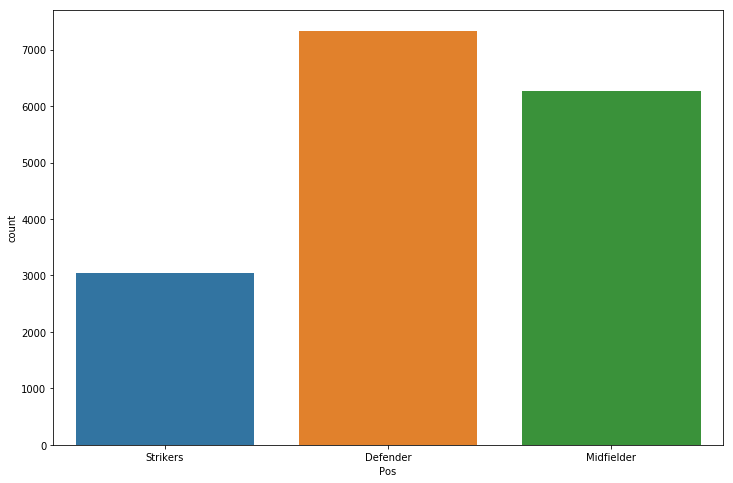

<Figure size 864x576 with 0 Axes>

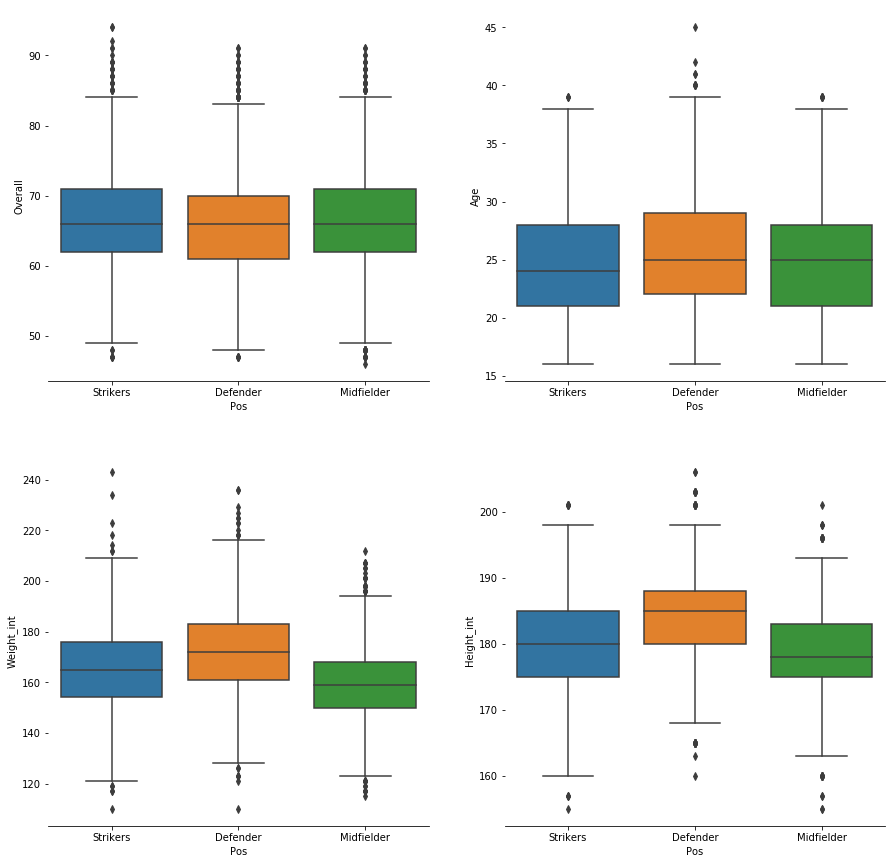

In [61]:

# Path of the file to read
fifa_filepath = "data.csv"
# Read the file into a variable iris_data
data = pd.read_csv(fifa_filepath)
# Print the first 5 rows of the data
data.head()


df2 = data.loc[:, 'Crossing':'Release Clause']
df1 = data[['Age', 'Overall', 'Value', 'Wage', 'Preferred Foot', 'Skill Moves', 'Position', 'Height', 'Weight']]
df = pd.concat([df1, df2], axis=1)

df = df.dropna()

def value_to_int(df_value):
    try:
        value = float(df_value[1:-1])
        suffix = df_value[-1:]

        if suffix == 'M':
            value = value * 1000000
        elif suffix == 'K':
            value = value * 1000
    except ValueError:
        value = 0
    return value
  
df['Value_float'] = df['Value'].apply(value_to_int)
df['Wage_float'] = df['Wage'].apply(value_to_int)
df['Release_Clause_float'] = df['Release Clause'].apply(lambda m: value_to_int(m))

def weight_to_int(df_weight):
    value = df_weight[:-3]
    return value
  
df['Weight_int'] = df['Weight'].apply(weight_to_int)
df['Weight_int'] = df['Weight_int'].apply(lambda x: int(x))

def height_to_int(df_height):
    try:
        feet = int(df_height[0])
        dlm = df_height[-2]

        if dlm == "'":
            height = round((feet * 12 + int(df_height[-1])) * 2.54, 0)
        elif dlm != "'":
            height = round((feet * 12 + int(df_height[-2:])) * 2.54, 0)
    except ValueError:
        height = 0
    return height

df['Height_int'] = df['Height'].apply(height_to_int)


df = df.drop(['Value', 'Wage', 'Release Clause', 'Weight', 'Height'], axis=1)

le_foot = preprocessing.LabelEncoder()
df["Preferred Foot"] = le_foot.fit_transform(df["Preferred Foot"].values)


for i in ['ST', 'CF', 'LF', 'LS', 'LW', 'RF', 'RS', 'RW']:
  df.loc[df.Position == i , 'Pos'] = 'Strikers' 

for i in ['CAM', 'CDM', 'LCM', 'CM', 'LAM', 'LDM', 'LM', 'RAM', 'RCM', 'RDM', 'RM']:
  df.loc[df.Position == i , 'Pos'] = 'Midfielder' 

for i in ['CB', 'LB', 'LCB', 'LWB', 'RB', 'RCB', 'RWB','GK']:
  df.loc[df.Position == i , 'Pos'] = 'Defender' 

plt.figure(figsize=(12, 8))
fig = sns.countplot(x = 'Pos', data =df)

plt.figure(figsize=(12, 8))

# Set up the matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(15, 15), sharex=False)
sns.despine(left=True)

sns.boxplot('Pos', 'Overall', data = df, ax=axes[0, 0])
sns.boxplot('Pos', 'Age', data = df, ax=axes[0, 1])

sns.boxplot('Pos', 'Height_int', data = df, ax=axes[1, 1])
sns.boxplot('Pos', 'Weight_int', data = df, ax=axes[1, 0])


from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
lasso = linear_model.Lasso()
from sklearn.model_selection import train_test_split

le_class = preprocessing.LabelEncoder()

df['Pos'] = le_class.fit_transform(df['Pos'])

y = df["Pos"]

df.drop(columns=["Position","Pos"],inplace=True)


X_train, X_test, y_train, y_test = train_test_split(df, y, 
                                                    test_size=0.20, 
                                                    random_state=50 )
print(X_train.shape)
print(X_test.shape)

print(X_train.info())


In [62]:

dtrain = xgb.DMatrix(X_train, label=y_train)

dtest = xgb.DMatrix(X_test,label=y_test)

param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3}  # the number of classes that exist in this datset
num_round = 50  # the number of training iterations

bst = xgb.train(param, dtrain, num_round)
bst.dump_model('dump.raw.txt')
preds = bst.predict(dtest)
preds_train = bst.predict(dtrain)


/home/bruno/anaconda3/envs/automl-3.6/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [43]:

best_preds = np.asarray([np.argmax(line) for line in preds])

best_preds_train = np.asarray([np.argmax(line) for line in preds_train])

cf_train = confusion_matrix(y_train, best_preds_train)

accuracy_score(y_train, best_preds_train)

cf = confusion_matrix(y_test, best_preds)

accuracy_score(y_test, best_preds)

0.8795434064283568

In [63]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from datetime import datetime

In [64]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [72]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.3,0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5,7]
        }

In [73]:
xgb_class = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='multi:logistic',
                    silent=True, nthread=1)

In [74]:
folds = 10
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb_class, param_distributions=params, n_iter=param_comb, n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )

start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train,y_train)
timer(start_time) # timing ends here for "start_time" variab

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 15.7min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 29.4min finished



 Time taken: 0 hours 31 minutes and 27.36 seconds.


In [76]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)


 All results:
{'mean_fit_time': array([123.83307462, 156.15468264, 185.07006083,  94.544155  ,
       107.83042774]), 'std_fit_time': array([ 4.54500911, 12.61772444, 12.00354495,  9.00954084,  9.26127255]), 'mean_score_time': array([0.81977794, 0.59102912, 0.92009988, 0.31810832, 0.48273175]), 'std_score_time': array([0.34516967, 0.09292102, 0.50814989, 0.07609309, 0.18893618]), 'param_subsample': masked_array(data=[0.6, 0.8, 0.8, 1.0, 0.8],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[10, 10, 10, 10, 5],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[7, 7, 7, 5, 5],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[2, 0.5, 0.5, 5, 0.5],
             mask=[False, False, False, False, False],
       

In [79]:
param = {'subsample': 0.8, 'min_child_weight': 10, 'max_depth': 7, 'gamma': 0.5, 'colsample_bytree': 1.0,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3}  # the number of classes that exist in this datset

num_round = 50  # the number of training iterations

bst = xgb.train(param, dtrain, num_round)
bst.dump_model('dump.raw.txt')
preds = bst.predict(dtest)
preds_train = bst.predict(dtrain)


In [83]:

best_preds = np.asarray([np.argmax(line) for line in preds])

best_preds_train = np.asarray([np.argmax(line) for line in preds_train])

cf_train = confusion_matrix(y_train, best_preds_train)

accuracy_score(y_train, best_preds_train)

cf = confusion_matrix(y_test, best_preds)

accuracy_score(y_test, best_preds)

0.885551216581556